In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import scipy
from sklearn.model_selection import GroupKFold
from sklearn import linear_model
from lineartree import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
def rae(actual, predicted):
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    return numerator / denominator

In [3]:
def peak_eV_nm(peak_eV):
    return 1239.84193/peak_eV

In [4]:
def FWHM_eV_nm(peak_eV,fwhm_eV):
    return  2*(1239.84193/(peak_eV-fwhm_eV/2) - 1239.84193/(peak_eV))

In [5]:
#Test Linear Regression on Train/Val set, 10-fold cross validation (Group splits), UV Peak, FWHM (eV), Normalized
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random forest regression models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 11, 
                                       min_samples_split = 12, 
                                       min_samples_leaf = 3, 
                                       max_features = 2,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=11, 
                                       min_samples_split = 5, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth= 11, 
                                       min_samples_split = 6, 
                                       min_samples_leaf = 3, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

#Split groups for cross validation by Experiment number
gkf = GroupKFold(n_splits=10)
matrix = np.zeros([10,13])
matrix_fwhm = np.zeros([10,13])
matrix_cascade = np.zeros([10,14])

j = 0
#Loop through the 10 splits
for train_index, test_index in gkf.split(X, groups=group):
    #Separate out training and test sets
    X_train = X.iloc[train_index, :]
    X2_train = X2.iloc[train_index, :]
    y_train = y[train_index]
    z_train = z[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    z_test = z[test_index]

    #prediction for Peak
    regressor_peak.fit(X_train, y_train)
    y_pred = regressor_peak.predict(X_test)
    #prediction for FWHM (direct)
    regressor_fwhm.fit(X_train, z_train)
    y_pred_fwhm = regressor_fwhm.predict(X_test)
    #prediction for FWHM (cascade)
    regressor_cascade.fit(X2_train, z_train)
    X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
    y_pred_cascade = regressor_cascade.predict(X_test)

    #errors in eV (normalized)
    
    #UN-normalize eV predictions by scaling with ratio

    ratio = (1239.84193/400 - 1239.84193/620)
    ratio2 = 0.35
    matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
    matrix[j,1] = metrics.r2_score(y_test, y_pred)
    matrix[j,2] = rae(y_test, y_pred)
    matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
    matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
    matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
    matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

    matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
    matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
    matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
    matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

    #errors in nm
    #UNnormalize the data first
    y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    z_test = z_test*(0.35)+0.05
    y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
    y_pred_cascade = y_pred_cascade*(0.35)+0.05
    
    #Calculate data in nm and eV
    matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
    matrix[j,8:13] = regressor_peak.feature_importances_

    matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
    matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

    matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
    matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

    j+=1

matrix_2 = np.zeros([1,21])
matrix_2[0,:8] = matrix.mean(0)[:8]
matrix_2[0,8:16] = np.std(matrix[:,:8], axis=0)
matrix_2[0,16:21] = matrix.mean(0)[8:13]

matrix_3 = np.zeros([1,21])
matrix_3[0,:8] = matrix_fwhm.mean(0)[:8]
matrix_3[0,8:16] = np.std(matrix_fwhm[:,:8], axis=0)
matrix_3[0,16:21] = matrix_fwhm.mean(0)[8:13]

matrix_4 = np.zeros([1,22])
matrix_4[0,:8] = matrix_cascade.mean(0)[:8]
matrix_4[0,8:16] = np.std(matrix_cascade[:,:8], axis=0)
matrix_4[0,16:22] = matrix_cascade.mean(0)[8:14]

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV): \t", "{:.4f}".format(matrix_2[0,0]), "{:.4f}".format(matrix_2[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_2[0,1]), "{:.4f}".format(matrix_2[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_2[0,2]), "{:.4f}".format(matrix_2[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_2[0,3]), "{:.4f}".format(matrix_2[0,11]))
print("Importances\t", matrix_2[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_2[0,4]), "{:.4f}".format(matrix_2[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_2[0,5]), "{:.4f}".format(matrix_2[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_2[0,6]), "{:.4f}".format(matrix_2[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_2[0,7]), "{:.4f}".format(matrix_2[0,15]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_3[0,0]), "{:.4f}".format(matrix_3[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_3[0,1]), "{:.4f}".format(matrix_3[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_3[0,2]), "{:.4f}".format(matrix_3[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_3[0,3]), "{:.4f}".format(matrix_3[0,11]))
print("Importances\t", matrix_3[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_3[0,4]), "{:.4f}".format(matrix_3[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_3[0,5]),"{:.4f}".format(matrix_3[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_3[0,6]), "{:.4f}".format(matrix_3[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_3[0,7]), "{:.4f}".format(matrix_3[0,15]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_4[0,0]), "{:.4f}".format(matrix_4[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_4[0,1]), "{:.4f}".format(matrix_4[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_4[0,2]), "{:.4f}".format(matrix_4[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_4[0,3]), "{:.4f}".format(matrix_4[0,11]))
print("Importances\t", matrix_4[0,16:22])
print("MAE (nm):\t","{:.4f}".format(matrix_4[0,4]), "{:.4f}".format(matrix_4[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_4[0,5]),"{:.4f}".format(matrix_4[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_4[0,6]), "{:.4f}".format(matrix_4[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_4[0,7]), "{:.4f}".format(matrix_4[0,15]))

np.savetxt("RF_UV_Val_peak.csv", matrix, delimiter=",")
np.savetxt("RF_UV_Val_fwhm.csv", matrix_fwhm, delimiter=",")
np.savetxt("RF_UV_Val_cascade.csv", matrix_cascade, delimiter=",")

Absorbance Peak
MAE (eV): 	 0.1936 0.0108
R2 (eV):	 0.3191 0.0586
RAE (eV):	 0.8228 0.0360
RMSE (eV):	 0.2436 0.0125
Importances	 [0.14379 0.15899 0.18296 0.09506 0.4192 ]
MAE (nm):	 42.2401 2.3756
R2 (nm):	 0.2846 0.0617
RAE (nm):	 0.8279 0.0343
RMSE (nm):	 54.2656 3.0813
Absorbance FWHM (direct)
MAE (eV):	 0.0155 0.0008
R2 (eV):	 0.5195 0.0415
RAE (eV):	 0.6617 0.0241
RMSE (eV):	 0.0203 0.0014
Importances	 [0.12912 0.18875 0.18    0.14719 0.35494]
MAE (nm):	 7.0681 0.3614
R2 (nm):	 0.2280 0.0570
RAE (nm):	 0.8523 0.0322
RMSE (nm):	 9.3864 0.6296
Absorbance FWHM (cascade)
MAE (eV):	 0.0155 0.0007
R2 (eV):	 0.5112 0.0471
RAE (eV):	 0.6633 0.0269
RMSE (eV):	 0.0205 0.0014
Importances	 [0.09765 0.17993 0.17178 0.13217 0.28699 0.13147]
MAE (nm):	 7.0688 0.3791
R2 (nm):	 0.2231 0.0605
RAE (nm):	 0.8523 0.0328
RMSE (nm):	 9.4170 0.6662


In [6]:
#Test Linear Regression on Train/Val set, 10-fold cross validation (Group splits), PL Peak, FWHM (eV), Normalized
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random Forest models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 11, 
                                       min_samples_split = 11, 
                                       min_samples_leaf = 10, 
                                       max_features = 2,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=13, 
                                       min_samples_split = 5, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth=15, 
                                       min_samples_split = 4, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

#Split groups for cross validation by Experiment number
gkf = GroupKFold(n_splits=10)
matrix = np.zeros([10,13])
matrix_fwhm = np.zeros([10,13])
matrix_cascade = np.zeros([10,14])

j = 0
#Loop through the 10 splits
for train_index, test_index in gkf.split(X, groups=group):
    #Separate out training and test sets
    X_train = X.iloc[train_index, :]
    X2_train = X2.iloc[train_index, :]
    y_train = y[train_index]
    z_train = z[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    z_test = z[test_index]

    #prediction for Peak
    regressor_peak.fit(X_train, y_train)
    y_pred = regressor_peak.predict(X_test)
    #prediction for FWHM (direct)
    regressor_fwhm.fit(X_train, z_train)
    y_pred_fwhm = regressor_fwhm.predict(X_test)
    #prediction for FWHM (cascade)
    regressor_cascade.fit(X2_train, z_train)
    X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
    y_pred_cascade = regressor_cascade.predict(X_test)

    #errors in eV (normalized)
    
    #UN-normalize eV predictions by scaling with ratio

    ratio = (1239.84193/400 - 1239.84193/620)
    ratio2 = 0.35
    matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
    matrix[j,1] = metrics.r2_score(y_test, y_pred)
    matrix[j,2] = rae(y_test, y_pred)
    matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
    matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
    matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
    matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

    matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
    matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
    matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
    matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

    #errors in nm
    #UNnormalize the data first
    y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    z_test = z_test*(0.35)+0.05
    y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
    y_pred_cascade = y_pred_cascade*(0.35)+0.05
    
    #Calculate data in nm and eV
    matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
    matrix[j,8:13] = regressor_peak.feature_importances_

    matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
    matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

    matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
    matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

    j+=1

matrix_2 = np.zeros([1,21])
matrix_2[0,:8] = matrix.mean(0)[:8]
matrix_2[0,8:16] = np.std(matrix[:,:8], axis=0)
matrix_2[0,16:21] = matrix.mean(0)[8:13]

matrix_3 = np.zeros([1,21])
matrix_3[0,:8] = matrix_fwhm.mean(0)[:8]
matrix_3[0,8:16] = np.std(matrix_fwhm[:,:8], axis=0)
matrix_3[0,16:21] = matrix_fwhm.mean(0)[8:13]

matrix_4 = np.zeros([1,22])
matrix_4[0,:8] = matrix_cascade.mean(0)[:8]
matrix_4[0,8:16] = np.std(matrix_cascade[:,:8], axis=0)
matrix_4[0,16:22] = matrix_cascade.mean(0)[8:14]

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_2[0,0]), "{:.4f}".format(matrix_2[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_2[0,1]), "{:.4f}".format(matrix_2[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_2[0,2]), "{:.4f}".format(matrix_2[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_2[0,3]), "{:.4f}".format(matrix_2[0,11]))
print("Importances\t", matrix_2[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_2[0,4]), "{:.4f}".format(matrix_2[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_2[0,5]), "{:.4f}".format(matrix_2[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_2[0,6]), "{:.4f}".format(matrix_2[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_2[0,7]), "{:.4f}".format(matrix_2[0,15]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_3[0,0]), "{:.4f}".format(matrix_3[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_3[0,1]), "{:.4f}".format(matrix_3[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_3[0,2]), "{:.4f}".format(matrix_3[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_3[0,3]), "{:.4f}".format(matrix_3[0,11]))
print("Importances\t", matrix_3[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_3[0,4]), "{:.4f}".format(matrix_3[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_3[0,5]),"{:.4f}".format(matrix_3[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_3[0,6]), "{:.4f}".format(matrix_3[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_3[0,7]), "{:.4f}".format(matrix_3[0,15]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_4[0,0]), "{:.4f}".format(matrix_4[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_4[0,1]), "{:.4f}".format(matrix_4[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_4[0,2]), "{:.4f}".format(matrix_4[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_4[0,3]), "{:.4f}".format(matrix_4[0,11]))
print("Importances\t", matrix_4[0,16:22])
print("MAE (nm):\t","{:.4f}".format(matrix_4[0,4]), "{:.4f}".format(matrix_4[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_4[0,5]),"{:.4f}".format(matrix_4[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_4[0,6]), "{:.4f}".format(matrix_4[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_4[0,7]), "{:.4f}".format(matrix_4[0,15]))

np.savetxt("RF_PL_Val_peak.csv", matrix, delimiter=",")
np.savetxt("RF_PL_Val_fwhm.csv", matrix_fwhm, delimiter=",")
np.savetxt("RF_PL_Val_cascade.csv", matrix_cascade, delimiter=",")

Emission Peak
MAE (eV):	 0.1880 0.0040
R2 (eV):	 0.2640 0.0309
RAE (eV):	 0.8534 0.0235
RMSE (eV):	 0.2375 0.0041
Importances	 [0.13493 0.17831 0.25547 0.08453 0.34677]
MAE (nm):	 43.6080 1.4943
R2 (nm):	 0.2391 0.0365
RAE (nm):	 0.8559 0.0236
RMSE (nm):	 56.1479 2.1185
Emission FWHM (direct)
MAE (eV):	 0.0143 0.0008
R2 (eV):	 0.4370 0.0694
RAE (eV):	 0.7371 0.0489
RMSE (eV):	 0.0188 0.0012
Importances	 [0.15214 0.16911 0.15751 0.14519 0.37604]
MAE (nm):	 6.6924 0.3001
R2 (nm):	 0.2077 0.0529
RAE (nm):	 0.8599 0.0312
RMSE (nm):	 8.9909 0.3708
Emission FWHM (cascade)
MAE (eV):	 0.0144 0.0007
R2 (eV):	 0.4188 0.0740
RAE (eV):	 0.7442 0.0502
RMSE (eV):	 0.0191 0.0012
Importances	 [0.11974 0.13296 0.12304 0.11739 0.27724 0.22964]
MAE (nm):	 6.7005 0.2966
R2 (nm):	 0.2025 0.0562
RAE (nm):	 0.8610 0.0319
RMSE (nm):	 9.0187 0.3586


In [7]:
#Train model on entire dataset (Absorbance)
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random forest regression models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 11, 
                                       min_samples_split = 12, 
                                       min_samples_leaf = 3, 
                                       max_features = 2,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=11, 
                                       min_samples_split = 5, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth= 11, 
                                       min_samples_split = 6, 
                                       min_samples_leaf = 3, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)



matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z
j=0

#prediction for Peak
regressor_peak.fit(X_train, y_train)
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
regressor_fwhm.fit(X_train, z_train)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
regressor_cascade.fit(X2_train, z_train)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
matrix[j,8:13] = regressor_peak.feature_importances_

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("Importances\t", matrix[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("Importances\t", matrix_fwhm[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("Importances\t", matrix_cascade[0,8:14])
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Absorption Peak/FWHM Training Accuracy
Absorbance Peak
MAE (eV):	 0.1758
R2 (eV):	 0.4466
RAE (eV):	 0.7450
RMSE (eV):	 0.2213
Importances	 [0.14481 0.1578  0.18656 0.09712 0.41371]
MAE (nm):	 38.4996
R2 (nm):	 0.4058
RAE (nm):	 0.7532
RMSE (nm):	 49.7055
Absorbance FWHM (direct)
MAE (eV):	 0.0115
R2 (eV):	 0.7377
RAE (eV):	 0.4894
RMSE (eV):	 0.0151
Importances	 [0.12998 0.18978 0.18142 0.14771 0.35112]
MAE (nm):	 6.1399
R2 (nm):	 0.4121
RAE (nm):	 0.7361
RMSE (nm):	 8.2441
Absorbance FWHM (cascade)
MAE (eV):	 0.0131
R2 (eV):	 0.6498
RAE (eV):	 0.5563
RMSE (eV):	 0.0175
Importances	 [0.09933 0.18321 0.17333 0.13242 0.28179 0.12992]
MAE (nm):	 6.3024
R2 (nm):	 0.3717
RAE (nm):	 0.7556
RMSE (nm):	 8.5225


In [8]:
#Test Linear model on interpolation, UV Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe UV Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_UV_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_UV_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_UV_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Interpolation
Absorbance Peak
MAE (eV):	 0.0579
R2 (eV):	 0.7995
RAE (eV):	 0.4393
RMSE (eV):	 0.0708
MAE (nm):	 12.0714
R2 (nm):	 0.8076
RAE (nm):	 0.4281
RMSE (nm):	 14.6054
Absorbance FWHM (direct)
MAE (eV):	 0.0123
R2 (eV):	 0.5986
RAE (eV):	 0.6175
RMSE (eV):	 0.0156
MAE (nm):	 2.7032
R2 (nm):	 0.6630
RAE (nm):	 0.5014
RMSE (nm):	 3.6603
Absorbance FWHM (cascade)
MAE (eV):	 0.0113
R2 (eV):	 0.6825
RAE (eV):	 0.5697
RMSE (eV):	 0.0139
MAE (nm):	 2.4521
R2 (nm):	 0.7352
RAE (nm):	 0.4548
RMSE (nm):	 3.2445


In [9]:
#Test Linear model on extrapolation, UV Peak, FWHM (eV)

#Test data set (extrapolation)
df2 = pd.read_csv('CdSe UV Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_UV_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_UV_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_UV_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Extrapolation
Absorbance Peak
MAE (eV):	 0.0484
R2 (eV):	 0.8932
RAE (eV):	 0.2921
RMSE (eV):	 0.0650
MAE (nm):	 10.3839
R2 (nm):	 0.8908
RAE (nm):	 0.2932
RMSE (nm):	 13.8373
Absorbance FWHM (direct)
MAE (eV):	 0.0124
R2 (eV):	 0.7415
RAE (eV):	 0.4587
RMSE (eV):	 0.0160
MAE (nm):	 2.7853
R2 (nm):	 0.4525
RAE (nm):	 0.6170
RMSE (nm):	 3.8905
Absorbance FWHM (cascade)
MAE (eV):	 0.0116
R2 (eV):	 0.7722
RAE (eV):	 0.4300
RMSE (eV):	 0.0151
MAE (nm):	 2.5124
R2 (nm):	 0.5244
RAE (nm):	 0.5565
RMSE (nm):	 3.6261


In [10]:
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

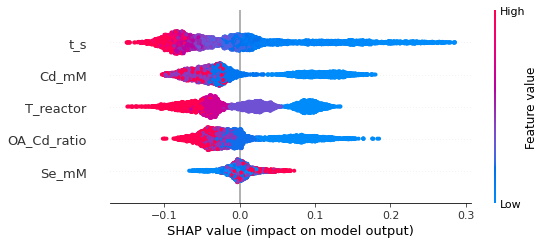

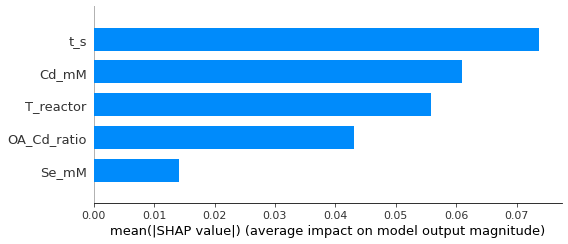

In [11]:
#SHAP on training data for Peak
import shap
tree_explainer = shap.TreeExplainer(regressor_peak)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

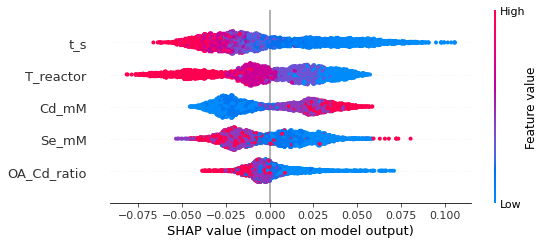

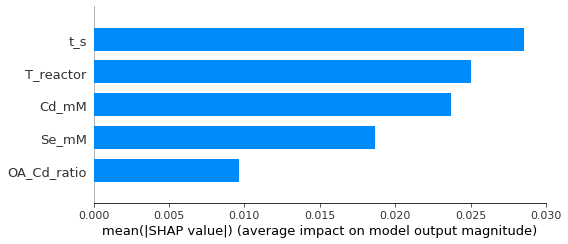

In [12]:
#SHAP on training data for FWHM
tree_explainer = shap.TreeExplainer(regressor_fwhm)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

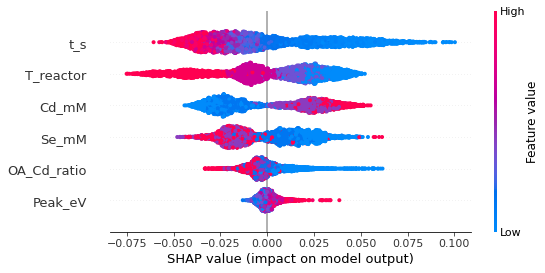

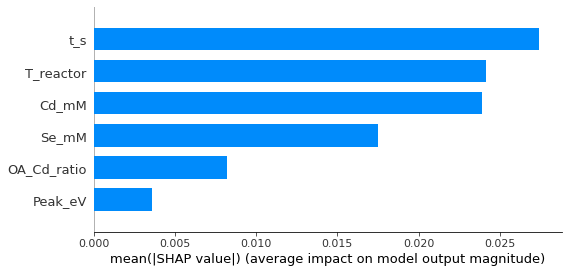

In [13]:
#SHAP on training data for Cascade
tree_explainer = shap.TreeExplainer(regressor_cascade)
shap_values = tree_explainer.shap_values(X2)
shap.summary_plot(shap_values, X2)
shap.summary_plot(shap_values, X2, plot_type="bar")

In [14]:
#Train model on entire dataset (Emission)
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random Forest models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 14, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 5,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=19, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth=18, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 2,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)
matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z
j=0

#prediction for Peak
regressor_peak.fit(X_train, y_train)
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
regressor_fwhm.fit(X_train, z_train)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
regressor_cascade.fit(X2_train, z_train)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
matrix[j,8:13] = regressor_peak.feature_importances_

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Training Accuracy' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("Importances\t", matrix[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("Importances\t", matrix_fwhm[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("Importances\t", matrix_cascade[0,8:14])
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Emission Peak/FWHM Training Accuracy
Emission Peak
MAE (eV):	 0.1251
R2 (eV):	 0.6779
RAE (eV):	 0.5657
RMSE (eV):	 0.1578
Importances	 [0.14979 0.13736 0.14773 0.15492 0.41021]
MAE (nm):	 29.3575
R2 (nm):	 0.6491
RAE (nm):	 0.5743
RMSE (nm):	 38.2893
Emission FWHM (direct)
MAE (eV):	 0.0084
R2 (eV):	 0.8085
RAE (eV):	 0.4289
RMSE (eV):	 0.0110
Importances	 [0.14373 0.16545 0.15533 0.15141 0.38407]
MAE (nm):	 4.3937
R2 (nm):	 0.6457
RAE (nm):	 0.5622
RMSE (nm):	 6.0421
Emission FWHM (cascade)
MAE (eV):	 0.0111
R2 (eV):	 0.6471
RAE (eV):	 0.5697
RMSE (eV):	 0.0150
Importances	 [0.12167 0.119   0.11319 0.10757 0.28859 0.24997]
MAE (nm):	 4.7275
R2 (nm):	 0.5750
RAE (nm):	 0.6049
RMSE (nm):	 6.6176


In [15]:
#Test Linear model on interpolation, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Interpolation' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_PL_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_PL_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_PL_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Emission Peak/FWHM Interpolation
Emission Peak
MAE (eV):	 0.0858
R2 (eV):	 0.4065
RAE (eV):	 0.7131
RMSE (eV):	 0.1094
MAE (nm):	 19.0073
R2 (nm):	 0.4483
RAE (nm):	 0.6909
RMSE (nm):	 23.8185
Emission FWHM (direct)
MAE (eV):	 0.0118
R2 (eV):	 0.4443
RAE (eV):	 0.6893
RMSE (eV):	 0.0174
MAE (nm):	 3.7243
R2 (nm):	 0.3217
RAE (nm):	 0.7886
RMSE (nm):	 5.0021
Emission FWHM (cascade)
MAE (eV):	 0.0105
R2 (eV):	 0.5157
RAE (eV):	 0.6173
RMSE (eV):	 0.0162
MAE (nm):	 3.4343
R2 (nm):	 0.3973
RAE (nm):	 0.7272
RMSE (nm):	 4.7151


In [16]:
#Test Linear model on extrapolation, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Extrapolation' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_PL_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_PL_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_PL_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Emission Peak/FWHM Extrapolation
Emission Peak
MAE (eV):	 0.0835
R2 (eV):	 0.4801
RAE (eV):	 0.6737
RMSE (eV):	 0.1046
MAE (nm):	 19.3184
R2 (nm):	 0.4867
RAE (nm):	 0.6639
RMSE (nm):	 24.2614
Emission FWHM (direct)
MAE (eV):	 0.0110
R2 (eV):	 0.4680
RAE (eV):	 0.6272
RMSE (eV):	 0.0148
MAE (nm):	 3.5241
R2 (nm):	 -0.0773
RAE (nm):	 0.9420
RMSE (nm):	 4.6396
Emission FWHM (cascade)
MAE (eV):	 0.0106
R2 (eV):	 0.5298
RAE (eV):	 0.6039
RMSE (eV):	 0.0139
MAE (nm):	 3.4403
R2 (nm):	 -0.0120
RAE (nm):	 0.9196
RMSE (nm):	 4.4967


In [17]:
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

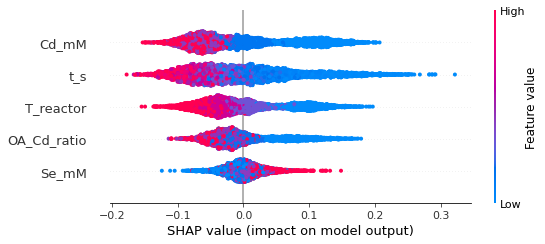

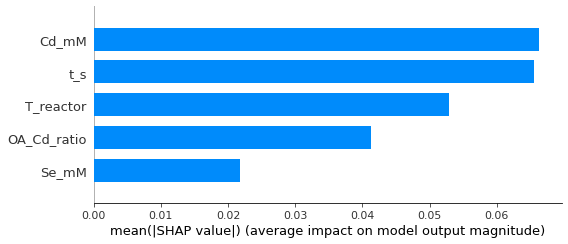

In [18]:
#SHAP on training data for Peak
import shap
tree_explainer = shap.TreeExplainer(regressor_peak)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

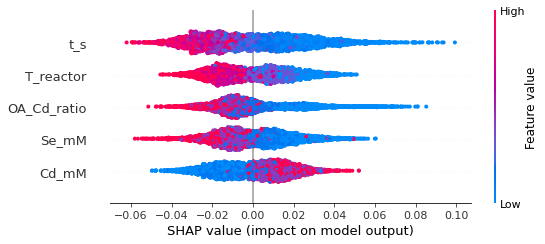

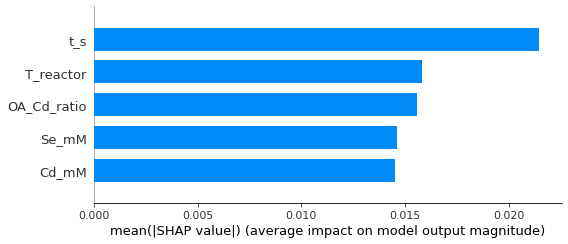

In [19]:
#SHAP on training data for FWHM
tree_explainer = shap.TreeExplainer(regressor_fwhm)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

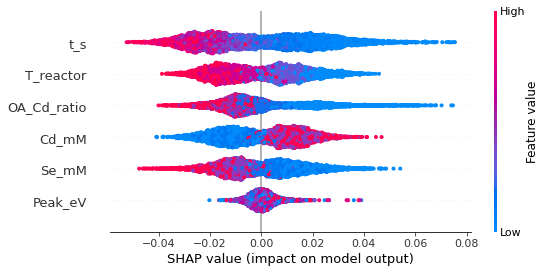

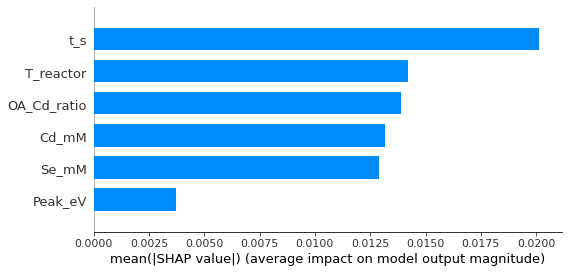

In [20]:
#SHAP on training data for FWHM (cascade)
tree_explainer = shap.TreeExplainer(regressor_cascade)
shap_values = tree_explainer.shap_values(X2)
shap.summary_plot(shap_values, X2)
shap.summary_plot(shap_values, X2, plot_type="bar")

In [27]:
rng = np.random.default_rng(seed=0)
random_data = rng.random((1000,6))

dfr = pd.DataFrame(random_data, columns=['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV'])

In [28]:
dfr

,OA_Cd_ratio,T_reactor,Cd_mM,Se_mM,t_s,Peak_eV
0,0.636962,0.269787,0.040974,0.016528,0.813270,0.912756
1,0.606636,0.729497,0.543625,0.935072,0.815854,0.002739
2,0.857404,0.033586,0.729655,0.175656,0.863179,0.541461
3,0.299712,0.422687,0.028320,0.124283,0.670624,0.647190
4,0.615385,0.383678,0.997210,0.980835,0.685542,0.650459
...,...,...,...,...,...,...
995,0.389722,0.702564,0.775430,0.463828,0.179526,0.130396
996,0.169614,0.110384,0.858528,0.293649,0.504306,0.113794
997,0.869846,0.025539,0.132788,0.331689,0.811300,0.313641
998,0.286012,0.088460,0.362215,0.693034,0.822817,0.785701


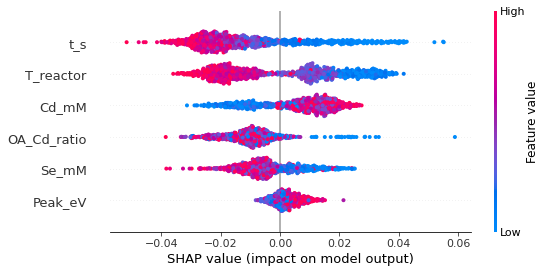

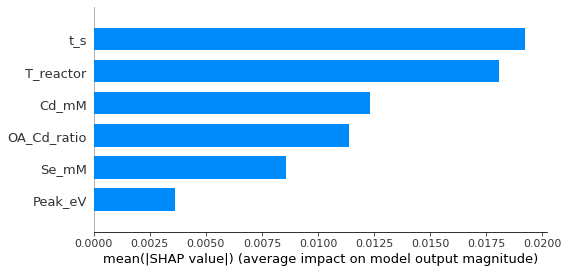

In [29]:
#SHAP on training data for FWHM (cascade)
tree_explainer = shap.TreeExplainer(regressor_cascade)
shap_values = tree_explainer.shap_values(dfr)
shap.summary_plot(shap_values, dfr)
shap.summary_plot(shap_values, dfr, plot_type="bar")